# Forecast Hydroloelectrical power energy using ResCNN architecture

## introduction and access to data

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot as aplot

import numpy as np
import pandas as pd
import math
from datetime import datetime as dt
from IPython.display import Image, HTML

from sklearn.model_selection import train_test_split

from arcgis.gis import GIS
from arcgis.learn import TimeSeriesModel, prepare_tabulardata
from arcgis.features import FeatureLayer, FeatureLayerCollection

## Login ArcGIS online

In [2]:
# Prompt user to provide username and password
import getpass
username = input('Enter username: ')
password = getpass.getpass("Enter your password: ") 
gis = GIS("https://udistritalfjc.maps.arcgis.com/home", username, password)

Enter username: Camendezv_UDFJC
Enter your password: ········


In [3]:
#import tables from ArcGIS online
## Capivara hydroelectric power station
Table1_HPP = gis.content.search("title:HPPCapivara* owner:camendezv_UDFJC")[0]
## Chavantes hydroelectric power station
Table2_HPP = gis.content.search("title:HPPChavantes* owner:camendezv_UDFJC")[1]
## Jurumirim hydroelectric power station
Table3_HPP = gis.content.search("title:HPPJurumirim* owner:camendezv_UDFJC")[1]

<Item title:"HPPCapivara" type:Table Layer owner:camendezv_UDFJC>
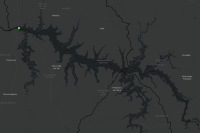

In [4]:
Table1_HPP

<Item title:"HPPChavantes" type:Table Layer owner:camendezv_UDFJC>
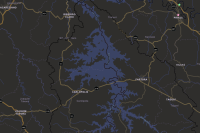

In [5]:
Table2_HPP

<Item title:"HPPJurumirim" type:Table Layer owner:camendezv_UDFJC>
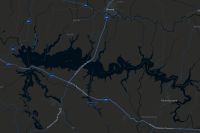

In [6]:
Table3_HPP

## Convert data into time series 

In [7]:
# Capivara
Data_Capivara = Table1_HPP.tables[0]
Series_Capivara_df = Data_Capivara.query().sdf
# Chavantes
Data_Chavantes = Table2_HPP.tables[0]
Series_Chavantes_df = Data_Chavantes.query().sdf
# Jurumirim
Data_Jurumirim = Table3_HPP.tables[0]
Series_Jurumirim_df = Data_Jurumirim.query().sdf

In [8]:
Series_Capivara_df.columns

Index(['OBJECTID', 'UsefulVolume', 'UsefulVolumePercent', 'AffluentFlow',
       'DefluentFlow', 'NaturalFlow', 'StoredEnergy', 'AffluentNaturalEnergy',
       'EnergyGeneration', 'Date'],
      dtype='object')

In [9]:
Series_Capivara_df = Series_Capivara_df.drop(["OBJECTID", "UsefulVolume", "UsefulVolumePercent", "StoredEnergy", "EnergyGeneration"], axis=1)
Series_Chavantes_df = Series_Chavantes_df.drop(["OBJECTID", "UsefulVolume", "UsefulVolumePercent", "StoredEnergy", "EnergyGeneration"], axis=1)
Series_Jurumirim_df = Series_Jurumirim_df.drop(["OBJECTID", "UsefulVolume", "UsefulVolumePercent", "StoredEnergy", "EnergyGeneration"], axis=1)

In [10]:
Series_Capivara_df['AffluentFlow'] = Series_Capivara_df['AffluentFlow'].astype('float64')
Series_Capivara_df['DefluentFlow'] = Series_Capivara_df['DefluentFlow'].astype('float64')
Series_Capivara_df['NaturalFlow'] = Series_Capivara_df['NaturalFlow'].astype('float64')
Series_Capivara_df['AffluentNaturalEnergy'] = Series_Capivara_df['AffluentNaturalEnergy'].astype('float64')

Series_Chavantes_df['AffluentFlow'] = Series_Chavantes_df['AffluentFlow'].astype('float64')
Series_Chavantes_df['DefluentFlow'] = Series_Chavantes_df['DefluentFlow'].astype('float64')
Series_Chavantes_df['NaturalFlow'] = Series_Chavantes_df['NaturalFlow'].astype('float64')
Series_Chavantes_df['AffluentNaturalEnergy'] = Series_Chavantes_df['AffluentNaturalEnergy'].astype('float64')

Series_Jurumirim_df['AffluentFlow'] = Series_Jurumirim_df['AffluentFlow'].astype('float64')
Series_Jurumirim_df['DefluentFlow'] = Series_Jurumirim_df['DefluentFlow'].astype('float64')
Series_Jurumirim_df['NaturalFlow'] = Series_Jurumirim_df['NaturalFlow'].astype('float64')
Series_Jurumirim_df['AffluentNaturalEnergy'] = Series_Jurumirim_df['AffluentNaturalEnergy'].astype('float64')


## Verify the information and properties of times series

In [11]:
Series_Capivara_df.info()
Series_Chavantes_df.info()
Series_Jurumirim_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AffluentFlow           8521 non-null   float64       
 1   DefluentFlow           8521 non-null   float64       
 2   NaturalFlow            8521 non-null   float64       
 3   AffluentNaturalEnergy  8521 non-null   float64       
 4   Date                   8521 non-null   datetime64[us]
dtypes: datetime64[us](1), float64(4)
memory usage: 333.0 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8521 entries, 0 to 8520
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   AffluentFlow           8521 non-null   float64       
 1   DefluentFlow           8521 non-null   float64       
 2   NaturalFlow            8521 non-null   float64       
 3   AffluentNatura

## Train - Test split of timeseries dataset

### Creating dataset for validation

In [12]:
# Capivara
CapivaraPredict_df = Series_Capivara_df.copy()
CapivaraPredict_df.loc[CapivaraPredict_df["Date"] > "2019-12-31" , "AffluentNaturalEnergy"] = np.NaN

# Chavantes
ChavantesPredict_df = Series_Chavantes_df.copy()
ChavantesPredict_df.loc[ChavantesPredict_df["Date"] > "2019-12-31" , "AffluentNaturalEnergy"] = np.NaN

#Jurumirim
JurumirimPredict_df = Series_Jurumirim_df.copy()
JurumirimPredict_df.loc[JurumirimPredict_df["Date"] > "2019-12-31" , "AffluentNaturalEnergy"] = np.NaN

### Creating dataset for training

In the previous section, 5 variables were defined per hydroelectric power plant, where each variable contains 8,521 records, these measurements or records represent the daily values of the time series during the period between 2001-01-01 and 2024-04-30 (23 years and 4 months). In this order of ideas, it is necessary to define the `training`, `validation` and `forecast` datasets in order to input them to the neural network.

In [13]:
#Capivara
test_size = 1582
Train_capivara, test_capivara = train_test_split(Series_Capivara_df, test_size=test_size, shuffle=False)
#Chavantes
test_size = 1582
Train_chavantes, test_chavantes = train_test_split(Series_Chavantes_df, test_size=test_size, shuffle=False)
#Jurumirim
test_size = 1582
Train_jurumirim, test_jurumirim = train_test_split(Series_Jurumirim_df, test_size=test_size, shuffle=False)

### Checking autocorrelation of time dependent variables

#### Capivara hydroelectric power station

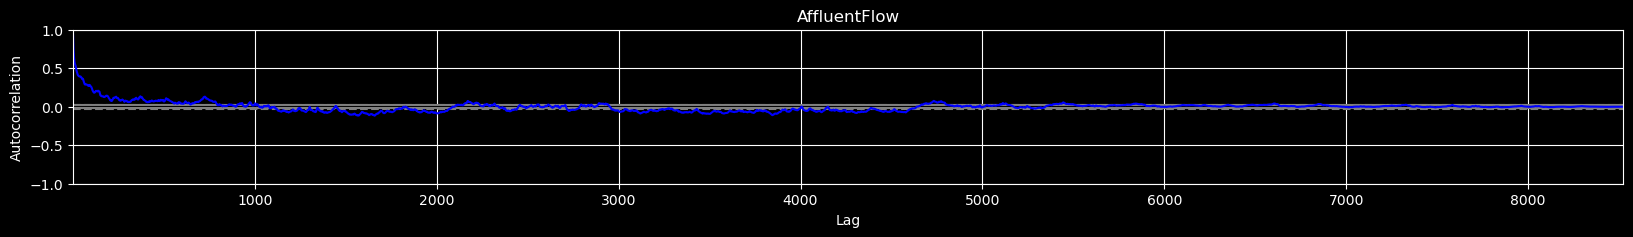

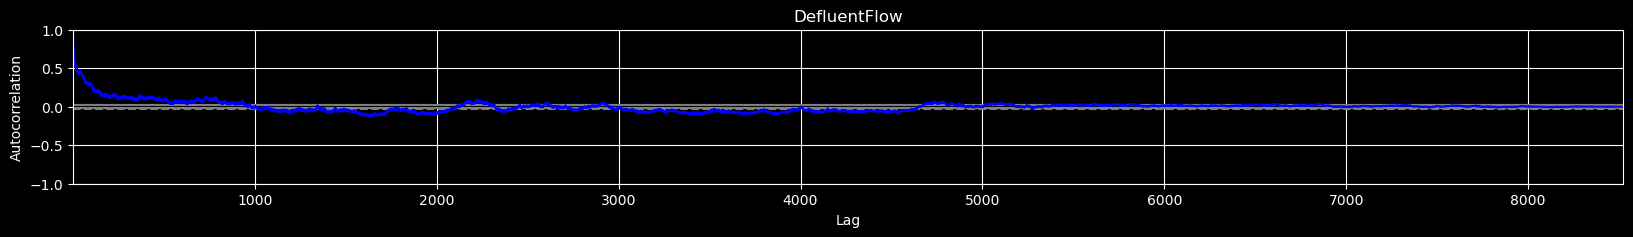

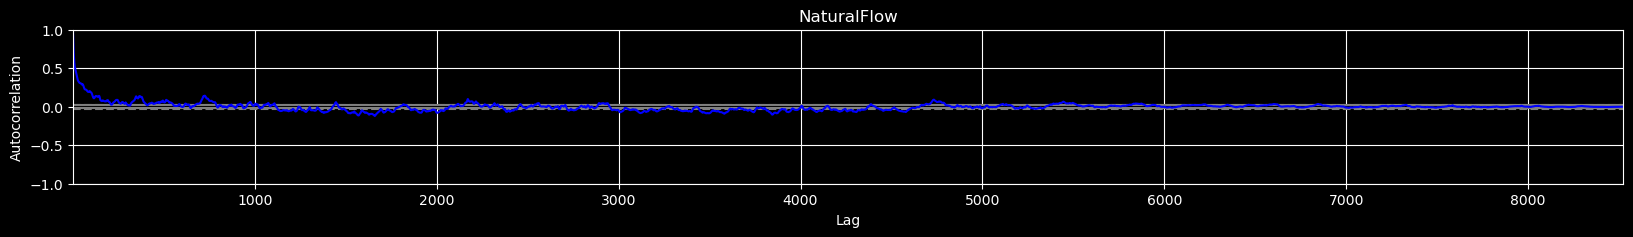

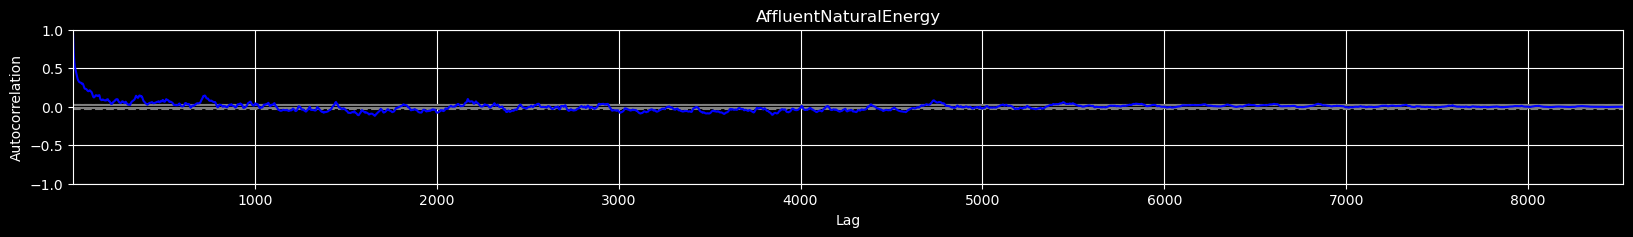

In [14]:
variables = ["AffluentFlow", "DefluentFlow", "NaturalFlow", "AffluentNaturalEnergy"]
for variable in variables:
    plt.figure(figsize=(20, 2))
    autocorr = aplot(Series_Capivara_df[variable], color="blue")
    plt.title(variable)

#### Chavantes hydroelectric power station

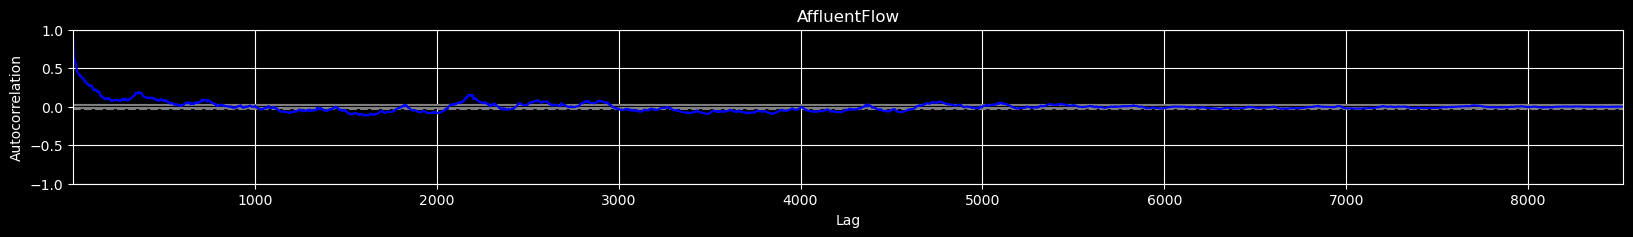

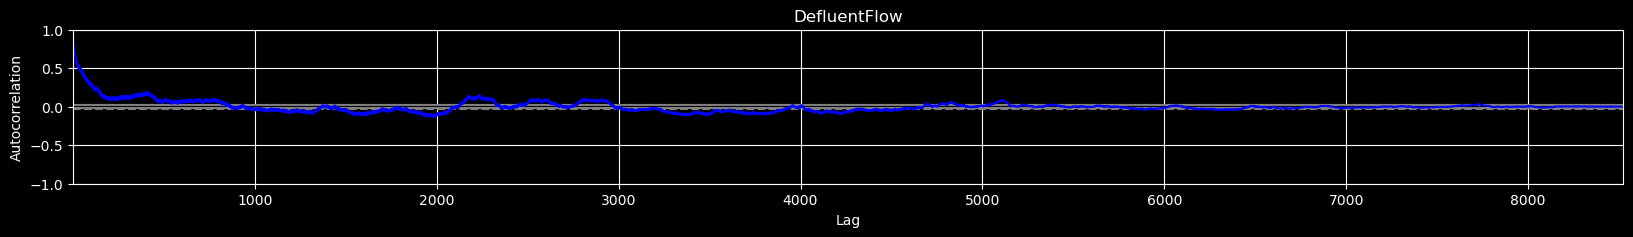

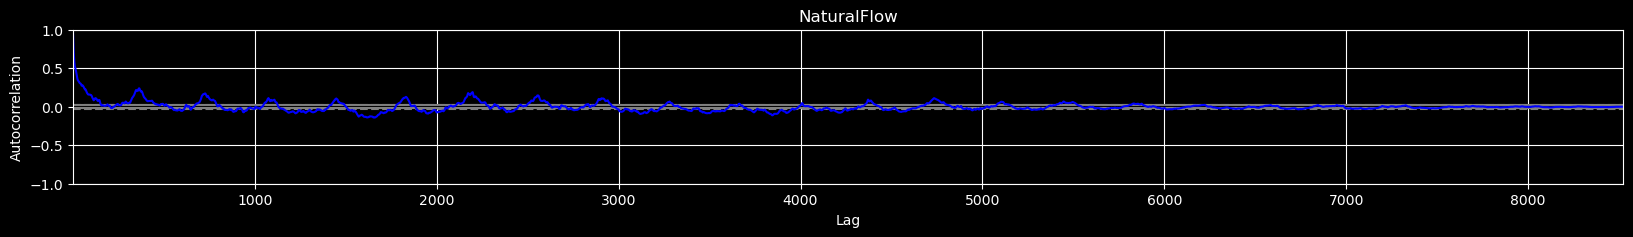

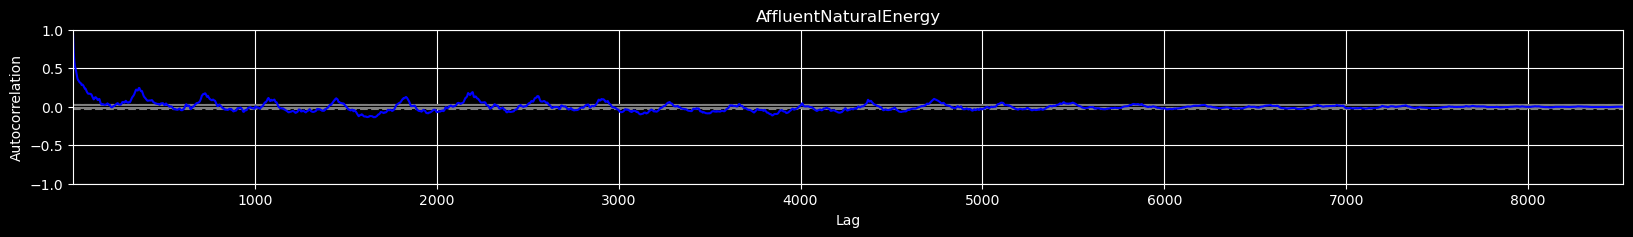

In [15]:
variables = ["AffluentFlow", "DefluentFlow", "NaturalFlow", "AffluentNaturalEnergy"]
for variable in variables:
    plt.figure(figsize=(20, 2))
    autocorr = aplot(Series_Chavantes_df[variable], color="blue")
    plt.title(variable)

#### Jurumirim hydroelectric power station

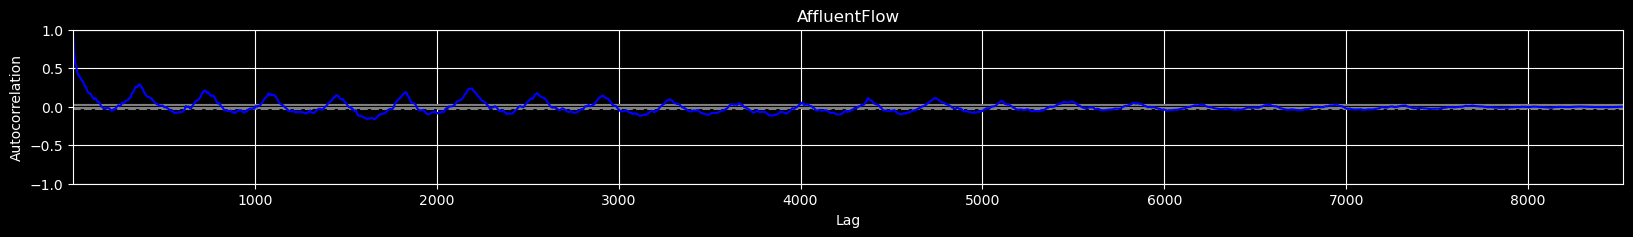

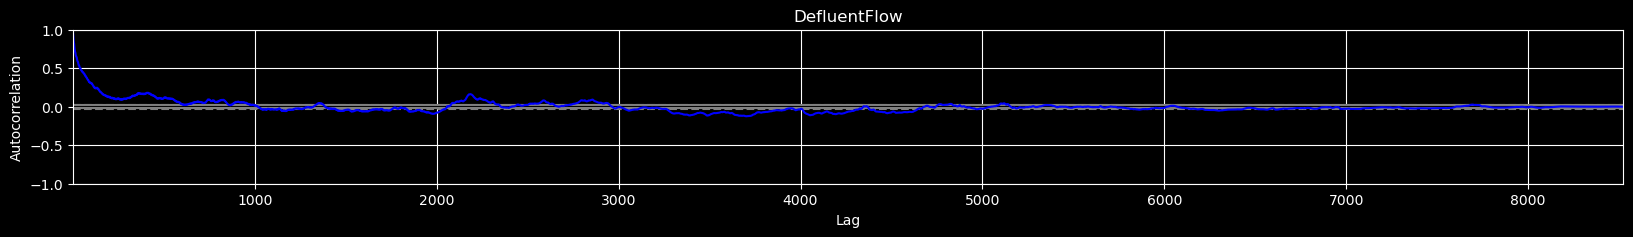

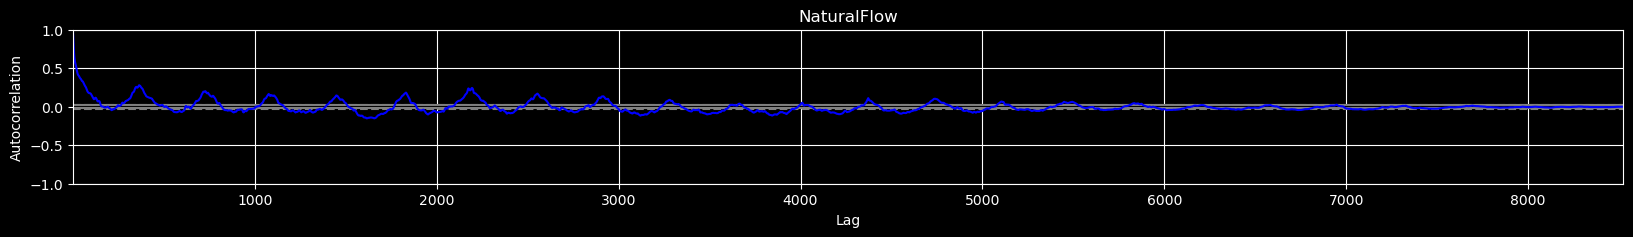

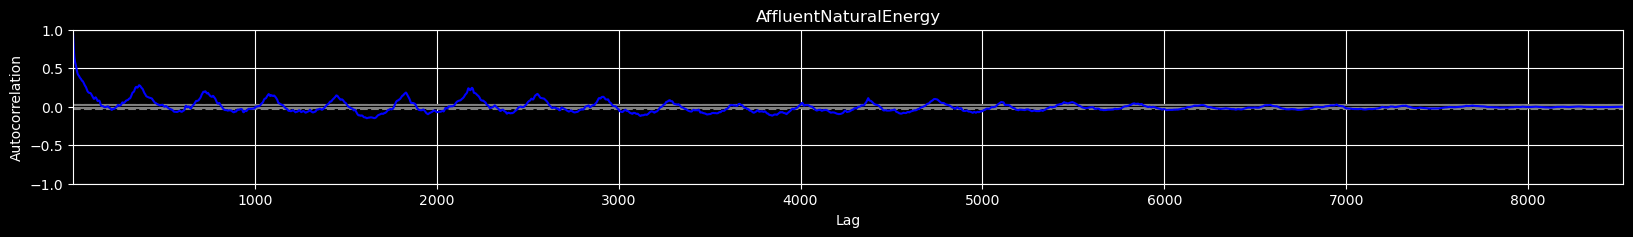

In [16]:
variables = ["AffluentFlow", "DefluentFlow", "NaturalFlow", "AffluentNaturalEnergy"]
for variable in variables:
    plt.figure(figsize=(20, 2))
    autocorr = aplot(Series_Jurumirim_df[variable], color="blue")
    plt.title(variable)

## Time series model building

### Data preprocessing

In [17]:
data_capivara = prepare_tabulardata(
    Train_capivara,
    variable_predict="AffluentNaturalEnergy",
    explanatory_variables=["AffluentFlow", "DefluentFlow", "NaturalFlow"],
    index_field="Date")

data_chavantes = prepare_tabulardata(
    Train_chavantes,
    variable_predict="AffluentNaturalEnergy",
    explanatory_variables=["AffluentFlow", "DefluentFlow", "NaturalFlow"],
    index_field="Date")

data_jurumirim = prepare_tabulardata(
    Train_jurumirim,
    variable_predict="AffluentNaturalEnergy",
    explanatory_variables=["AffluentFlow", "DefluentFlow", "NaturalFlow"],
    index_field="Date")

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\models\_arcgis_model.py:461: UserWarning:

Cuda is not available

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work

C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\arcgis\learn\_utils\tabular_data.py:1871: UserWarning:

Dataframe is not spatial, Rasters and distance layers will not work



### Plot the time series by hydroelectric power station

#### Capivara 

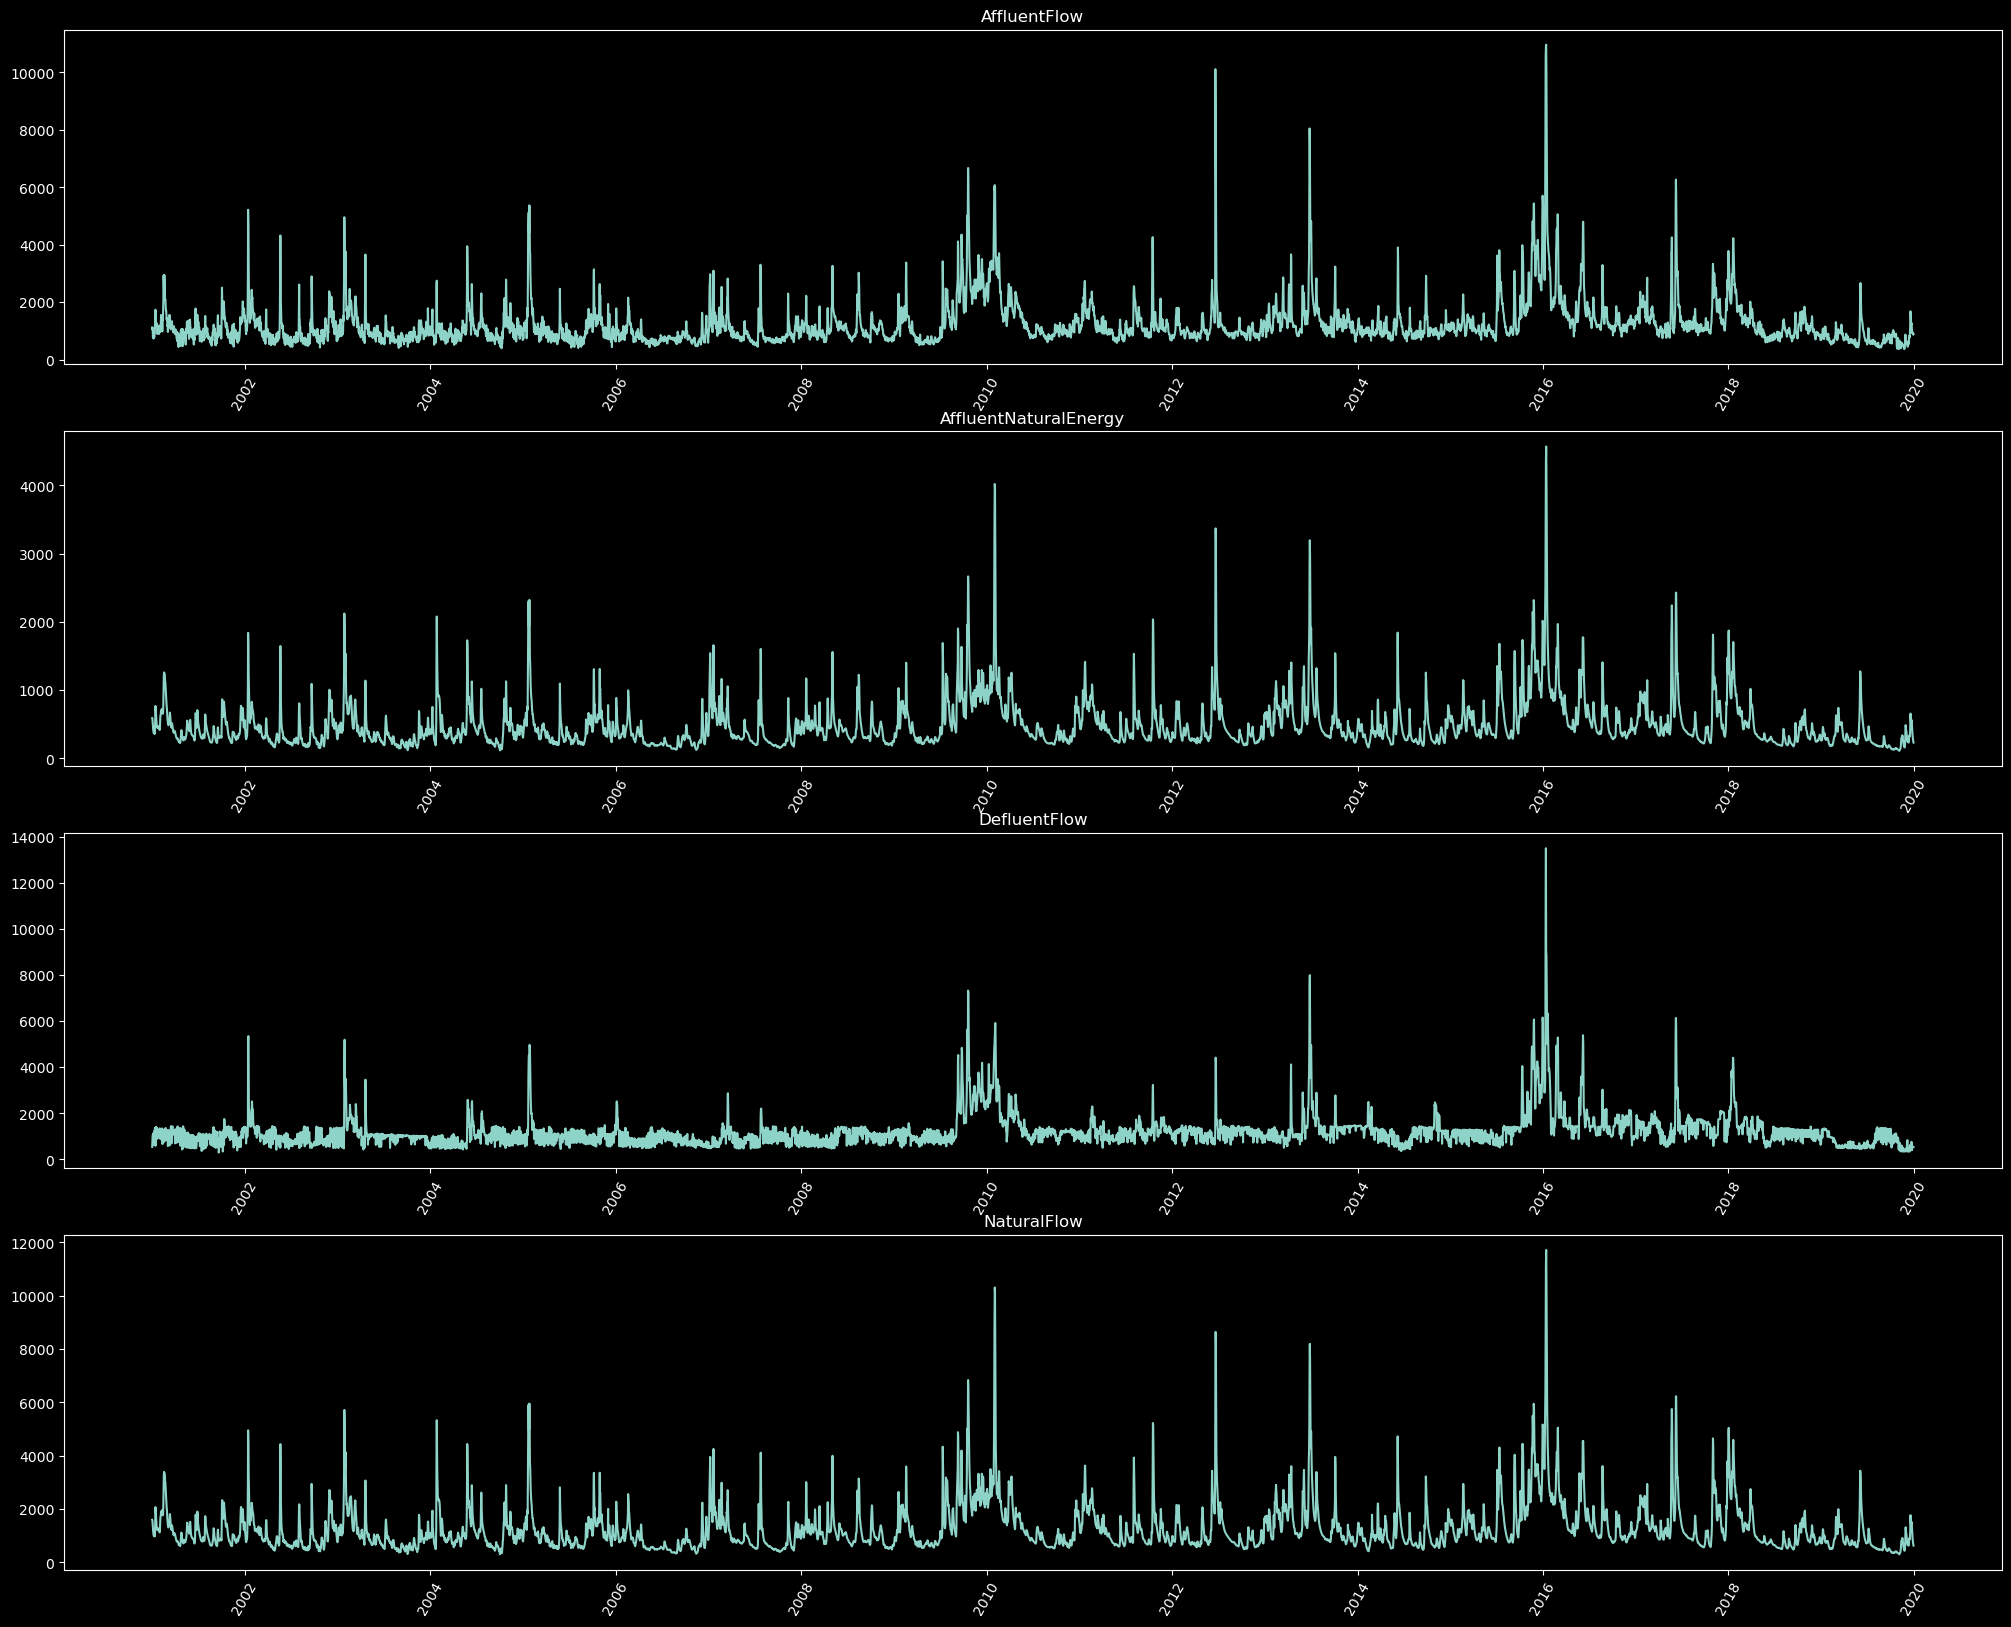

In [18]:
# Visualize the entire timeseries data
data_capivara.show_batch(graph=True)

#### Chavantes 

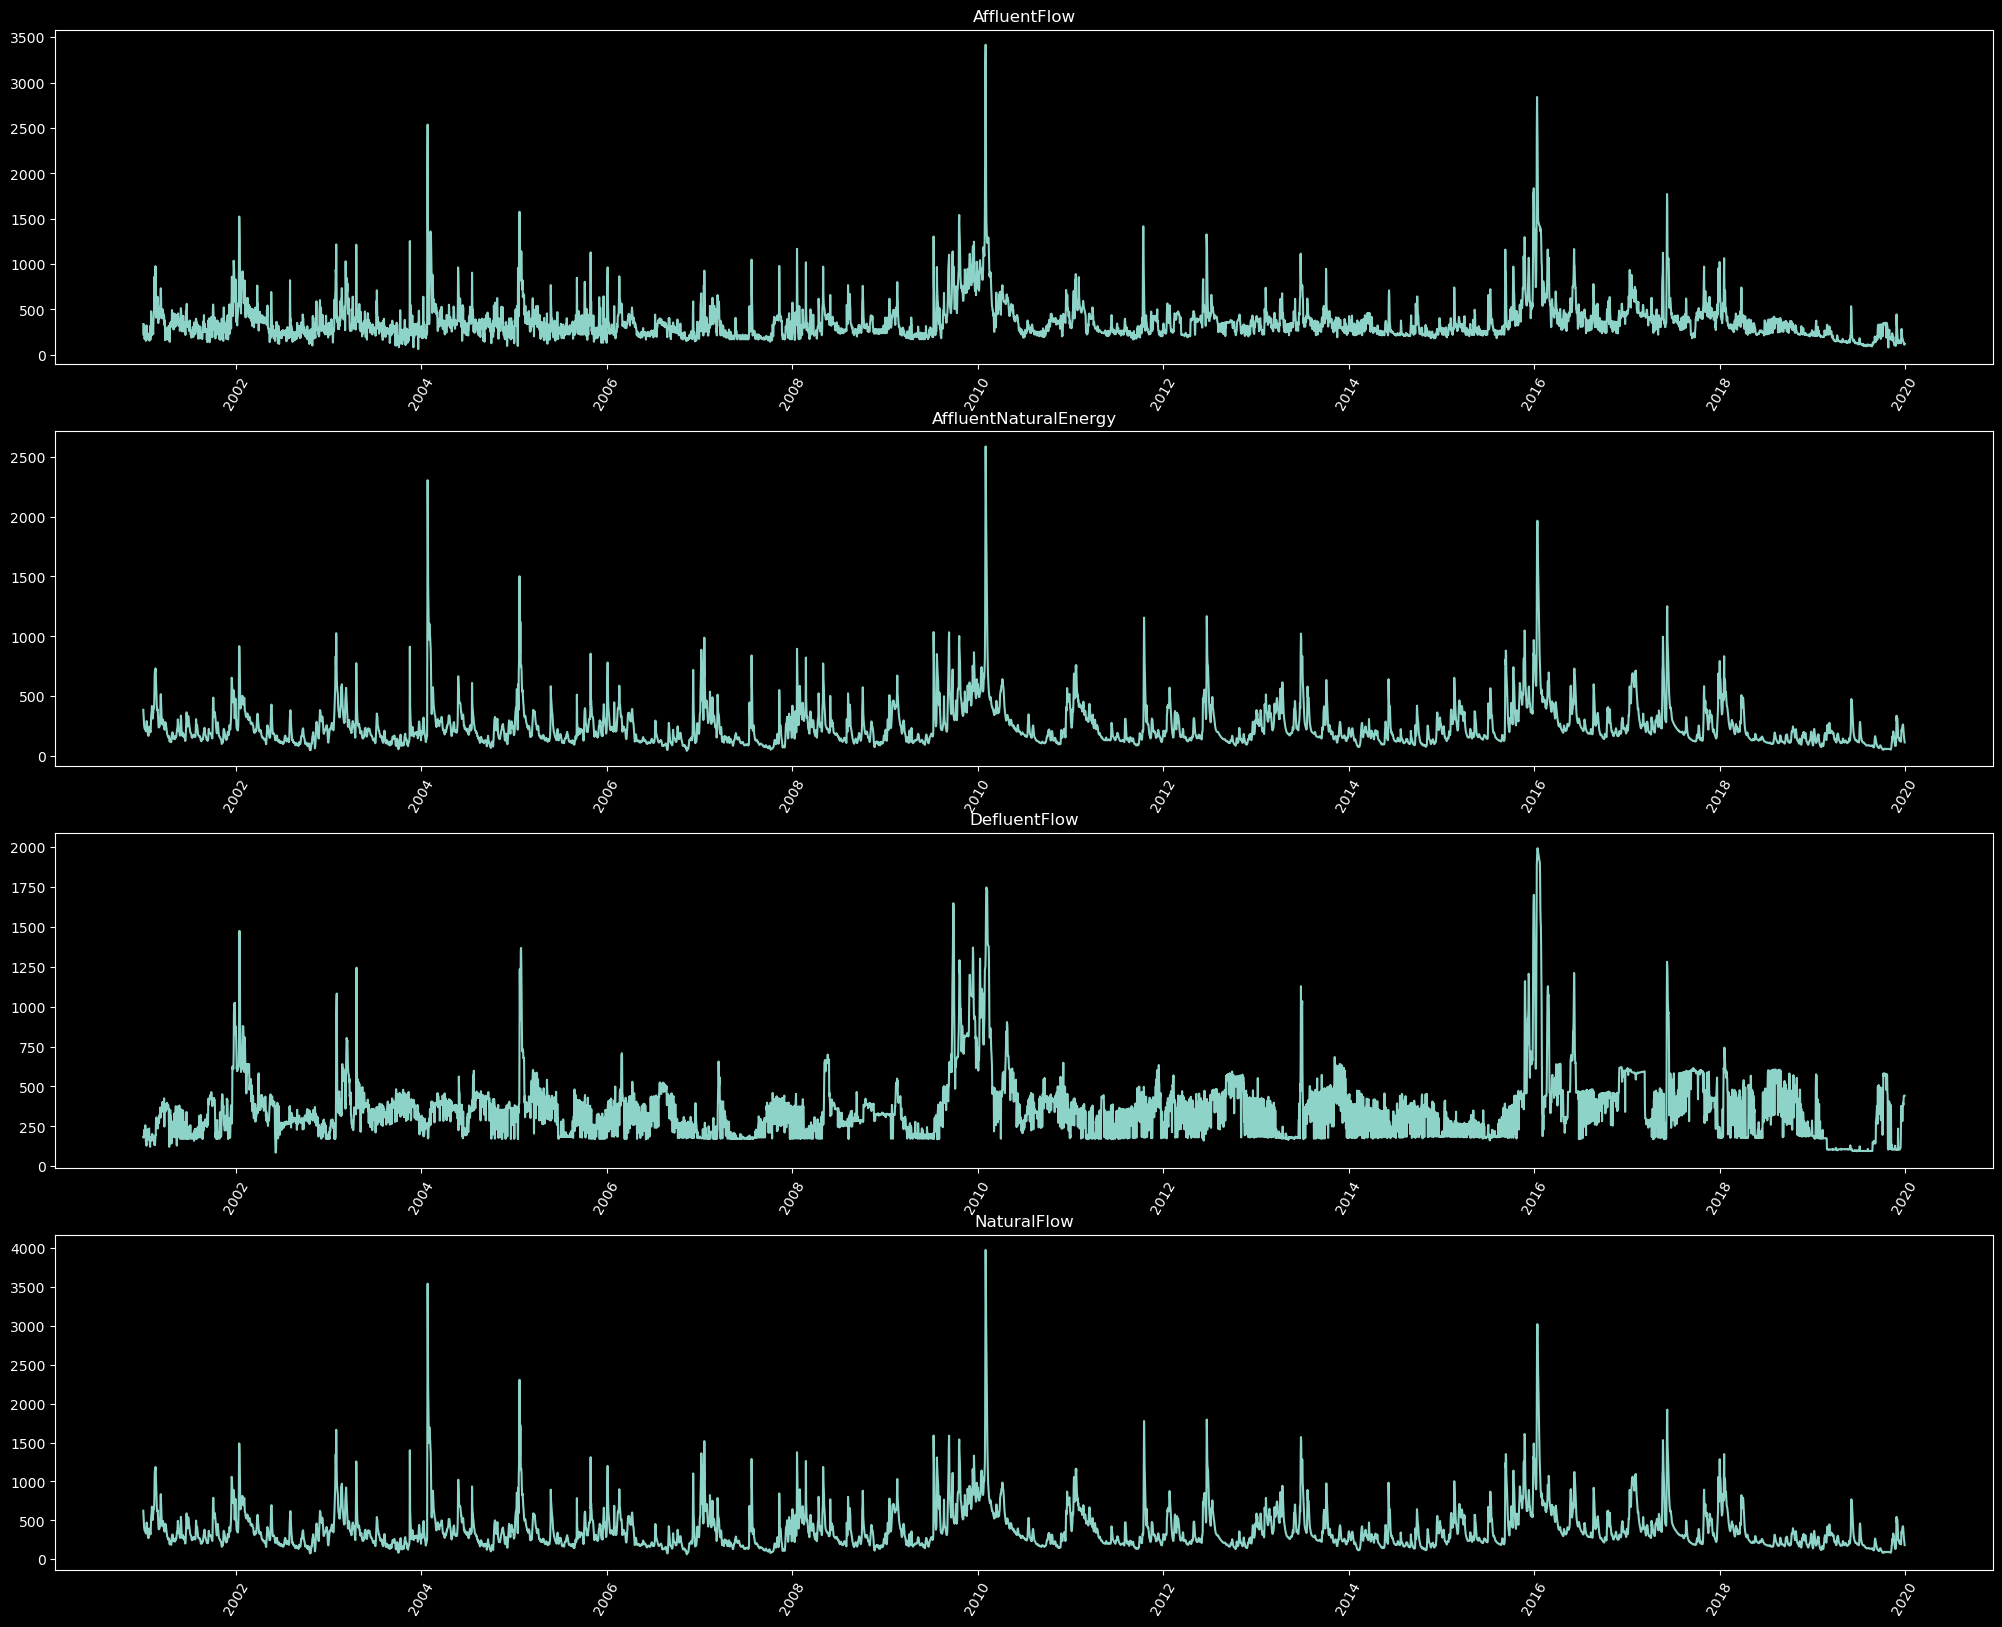

In [19]:
# Visualize the entire timeseries data
data_chavantes.show_batch(graph=True)

#### Jurumirim 

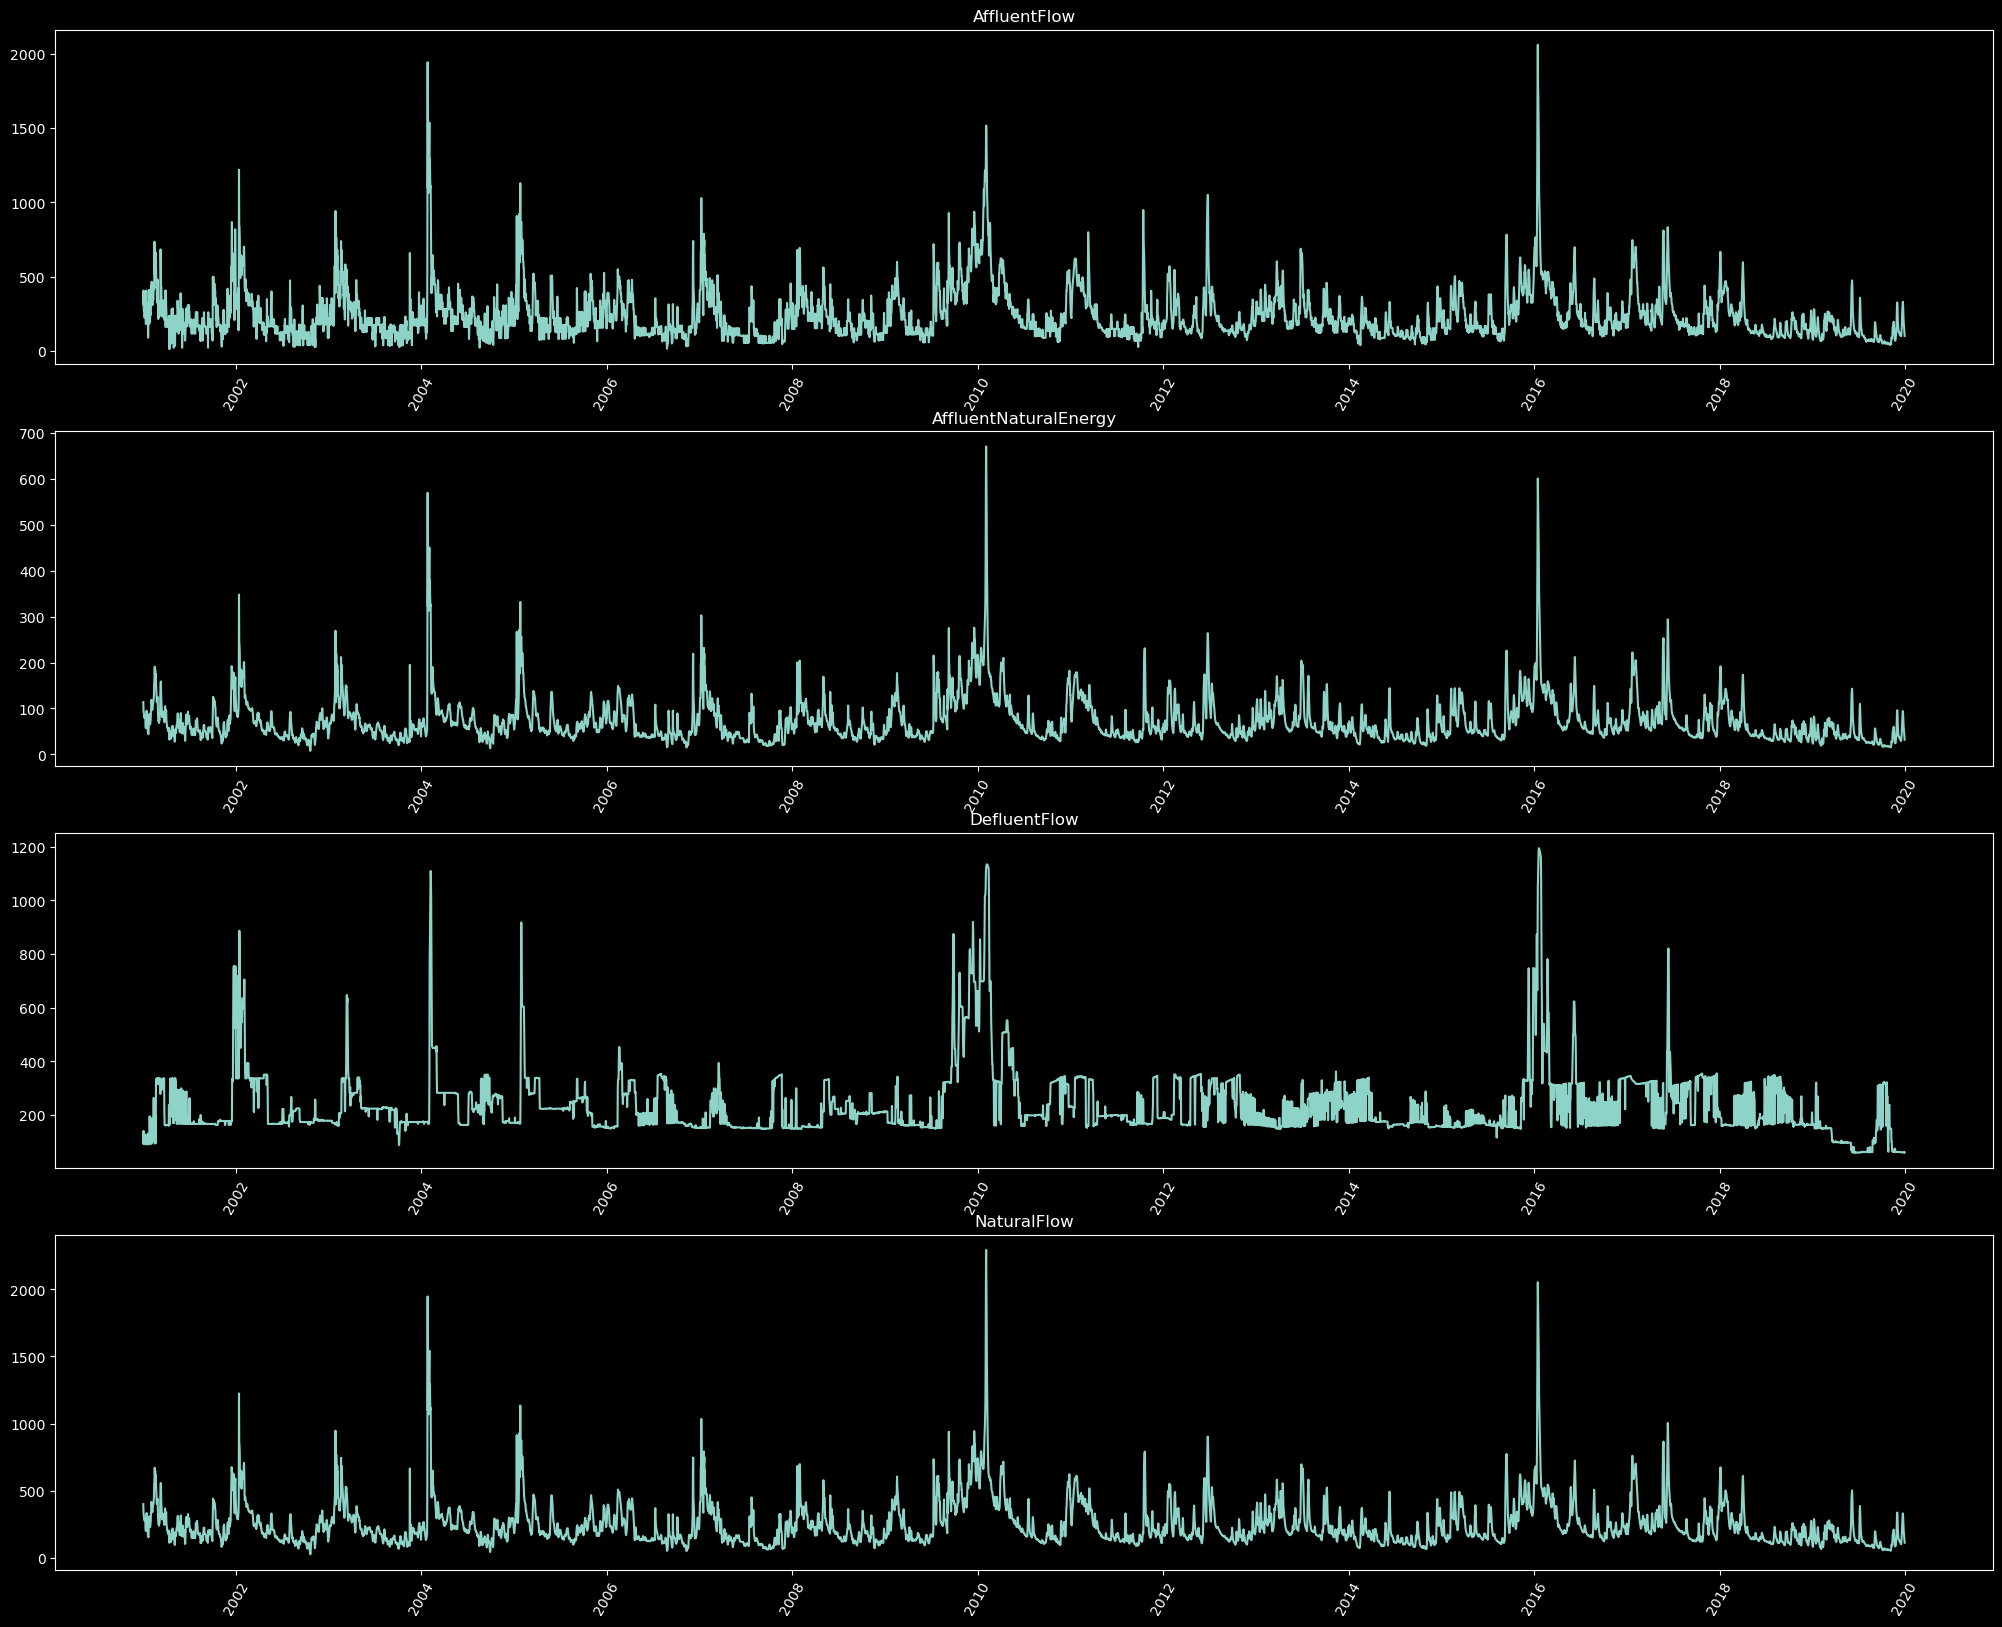

In [20]:
# Visualize the entire timeseries data
data_jurumirim.show_batch(graph=True)

### Compare the Affluent Flow, Stored Energy and Affluent Natural Energy

In [21]:
# Here sequence length is used as 12 which also indicates the seasonality of the data
seq_len = 365

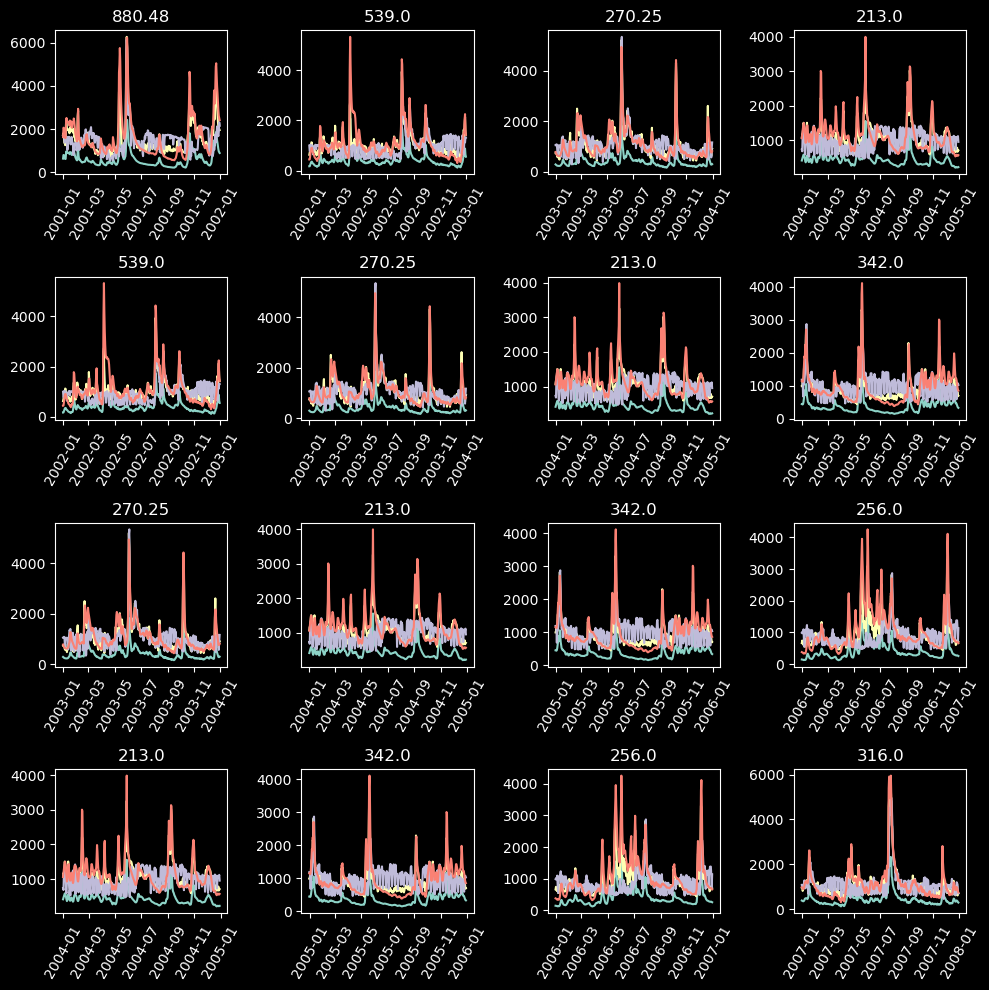

In [22]:
data_capivara.show_batch(rows=4, seq_len=seq_len)

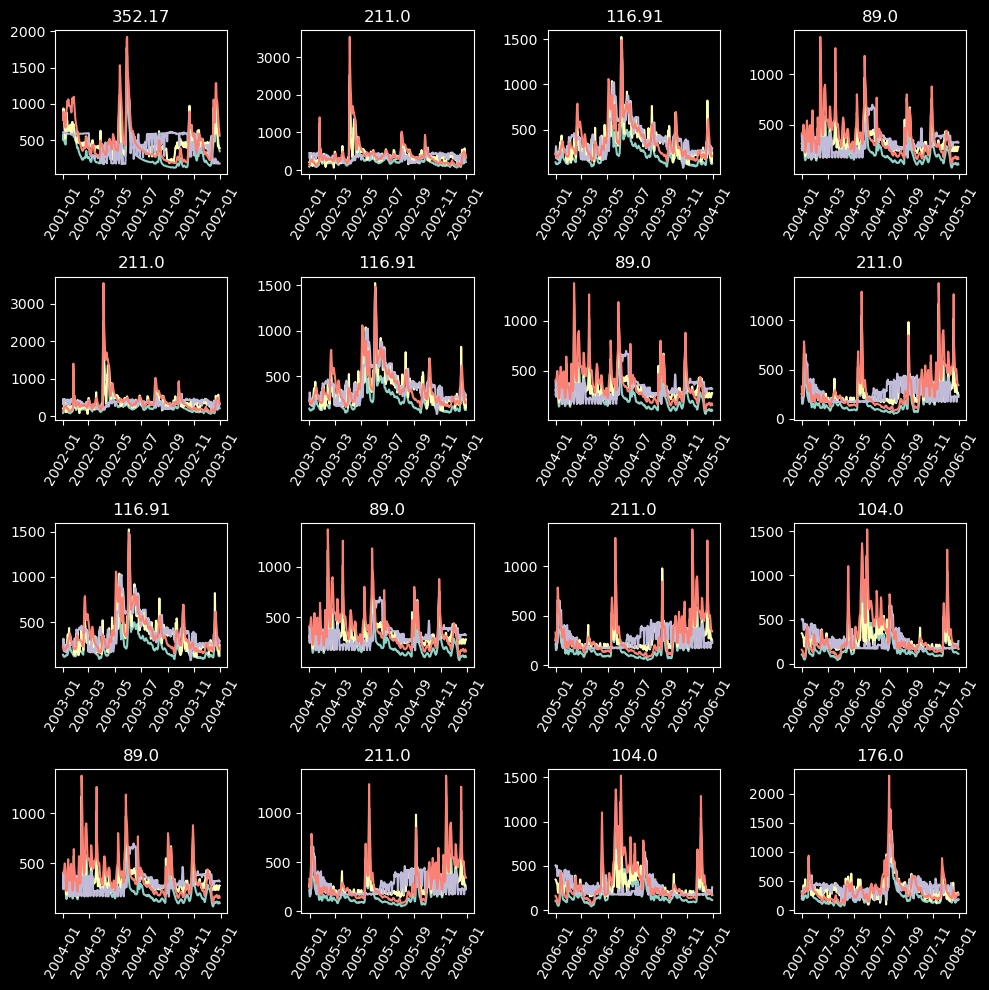

In [23]:
data_chavantes.show_batch(rows=4, seq_len=seq_len)

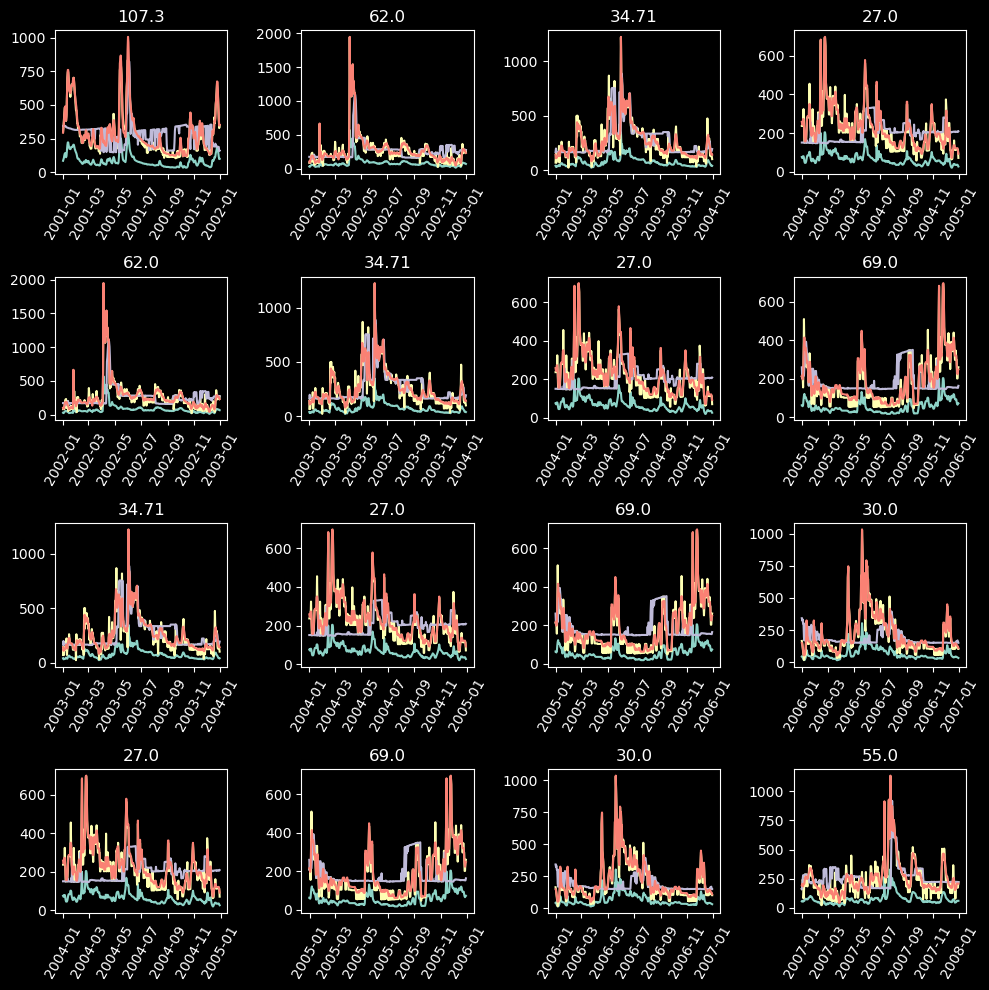

In [24]:
data_jurumirim.show_batch(rows=4, seq_len=seq_len)

### Model initialization

#### Capivara

In [25]:
tsmodel_capivara = TimeSeriesModel(data_capivara, seq_len=seq_len, model_arch="ResCNN")

#### Chavantes 

In [26]:
tsmodel_chavantes = TimeSeriesModel(data_chavantes, seq_len=seq_len, model_arch="ResCNN")

#### Jurumirim 

In [27]:
tsmodel_jurumirim = TimeSeriesModel(data_jurumirim, seq_len=seq_len, model_arch="ResCNN")

## Learning rate search 

Here, we find the optimal learning rate for training the model.

### Capivara 

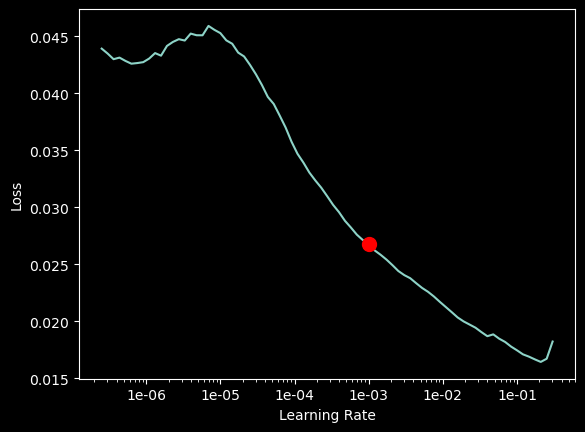

0.001

In [28]:
lr_rate_capivara = tsmodel_capivara.lr_find()
lr_rate_capivara

### Chavantes 

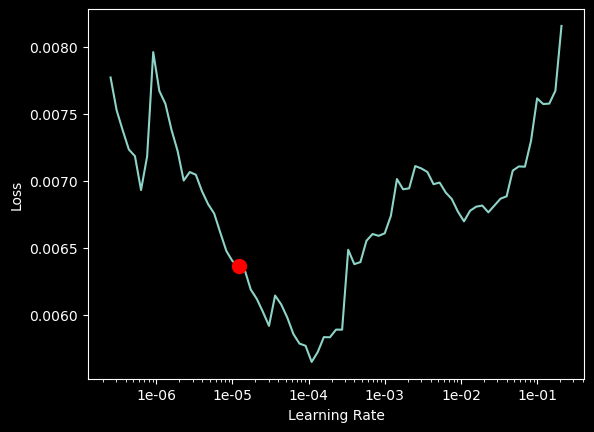

1.202264434617413e-05

In [29]:
lr_rate_chavantes = tsmodel_chavantes.lr_find()
lr_rate_chavantes

### Jurumirim 

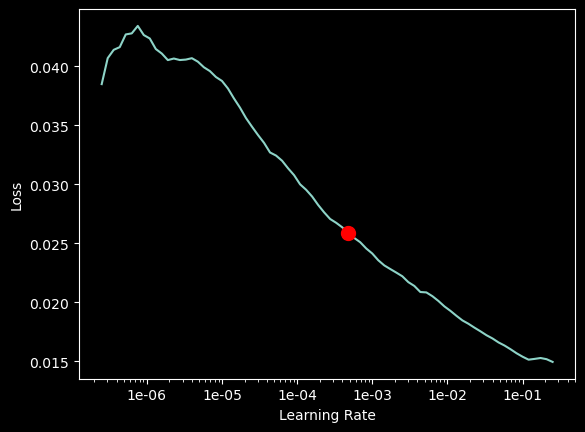

0.0004786300923226385

In [30]:
lr_rate_jurumirim = tsmodel_jurumirim.lr_find()
lr_rate_jurumirim

## Model training  

### Capivara 

In [31]:
tsmodel_capivara.fit(10, lr=lr_rate_capivara)

epoch     train_loss  valid_loss  time    
0         0.005859    0.004428    01:33     
1         0.003347    0.003175    01:35     
2         0.001454    0.000560    01:35     
3         0.000895    0.000494    01:32     
4         0.000964    0.001183    01:45     
5         0.000706    0.000791    01:38     
6         0.000567    0.000440    01:38     
7         0.000507    0.000279    01:30     
8         0.000428    0.000258    01:27     
9         0.000373    0.000223    01:38     


C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\fastai\sixel.py:16: UserWarning:

You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel



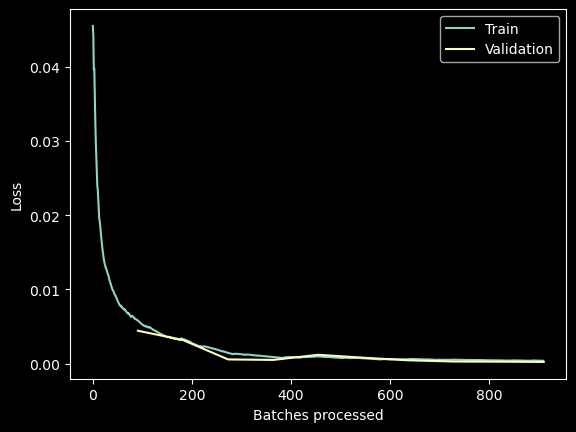

In [32]:
tsmodel_capivara.plot_losses()

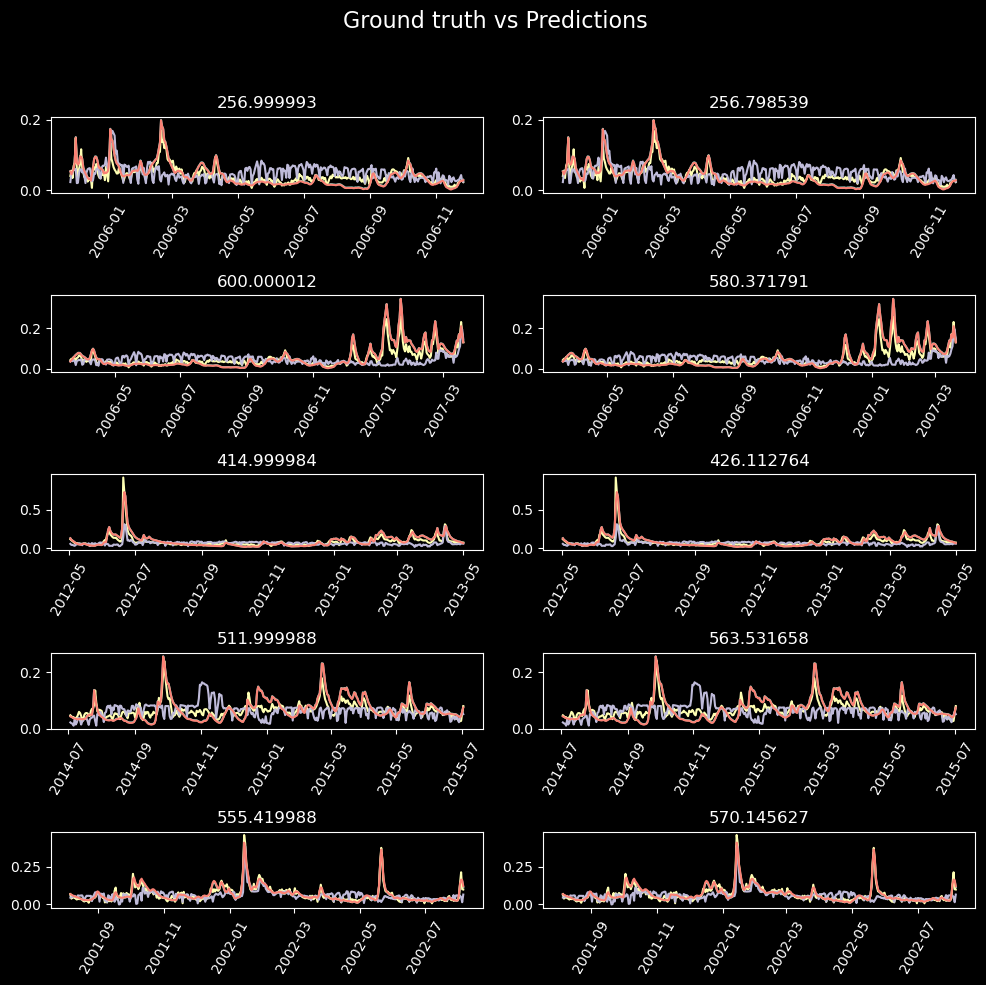

In [33]:
tsmodel_capivara.show_results(rows=5)

### Chavantes 

In [34]:
tsmodel_chavantes.fit(10, lr=lr_rate_chavantes)

epoch     train_loss  valid_loss  time    
0         0.006336    0.004631    01:35     
1         0.004935    0.003952    01:23     
2         0.004271    0.003711    01:33     
3         0.004118    0.003419    01:24     
4         0.003802    0.003127    01:24     
5         0.003409    0.003083    01:23     
6         0.003340    0.003106    01:23     
7         0.003040    0.002864    01:22     
8         0.003138    0.002850    01:31     
9         0.002960    0.002845    01:23     


C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\fastai\sixel.py:16: UserWarning:

You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel



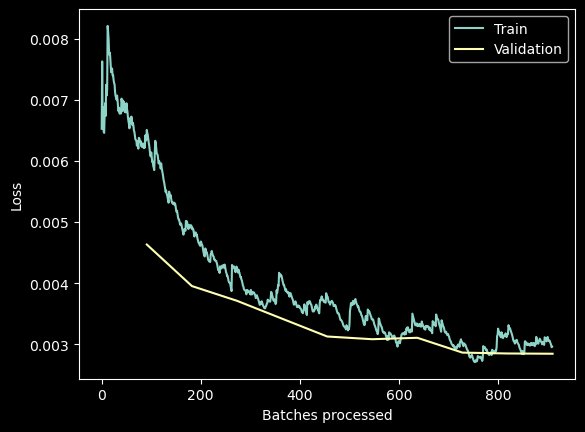

In [35]:
tsmodel_chavantes.plot_losses()

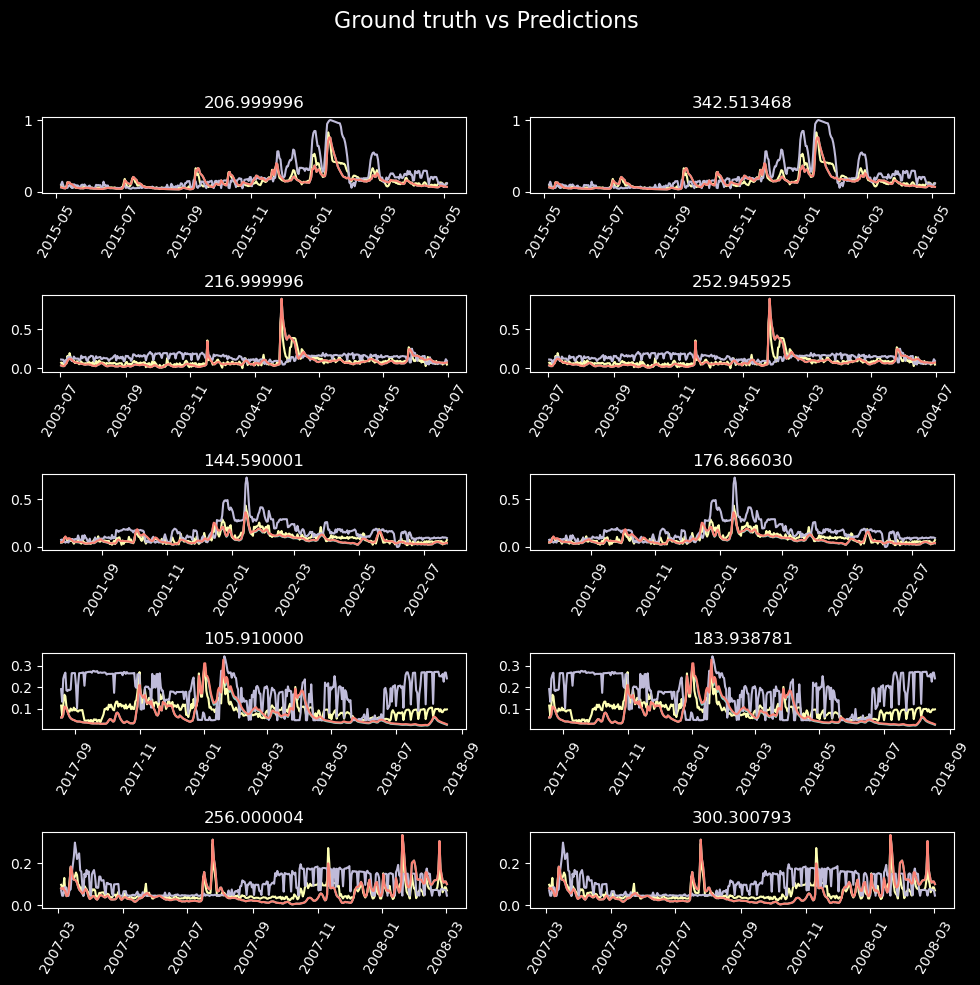

In [36]:
tsmodel_chavantes.show_results(rows=5)

### Jurumirim 

In [37]:
tsmodel_jurumirim.fit(10, lr=lr_rate_jurumirim)

epoch     train_loss  valid_loss  time    
0         0.006308    0.003095    01:28     
1         0.003036    0.002549    01:31     
2         0.001940    0.001322    01:23     
3         0.001513    0.001533    01:23     
4         0.001038    0.001202    01:31     
5         0.000903    0.000822    01:30     
6         0.000824    0.000502    01:31     
7         0.000751    0.000407    01:31     
8         0.000593    0.000422    01:23     
9         0.000518    0.000403    01:30     


C:\Users\57320\AppData\Local\Programs\ArcGIS\Pro\bin\Python\envs\arcgispro-py3\lib\site-packages\fastai\sixel.py:16: UserWarning:

You could see this plot with `libsixel`. See https://github.com/saitoha/libsixel



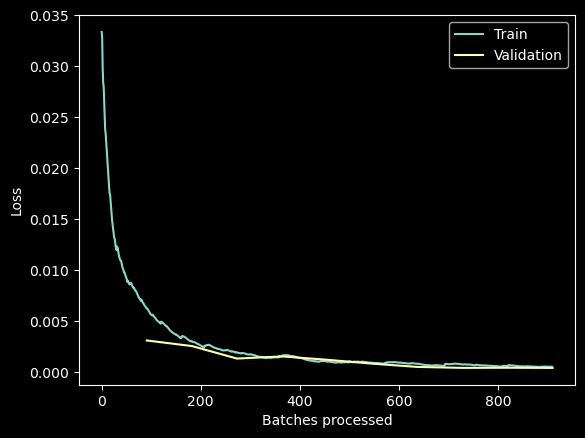

In [38]:
tsmodel_jurumirim.plot_losses()

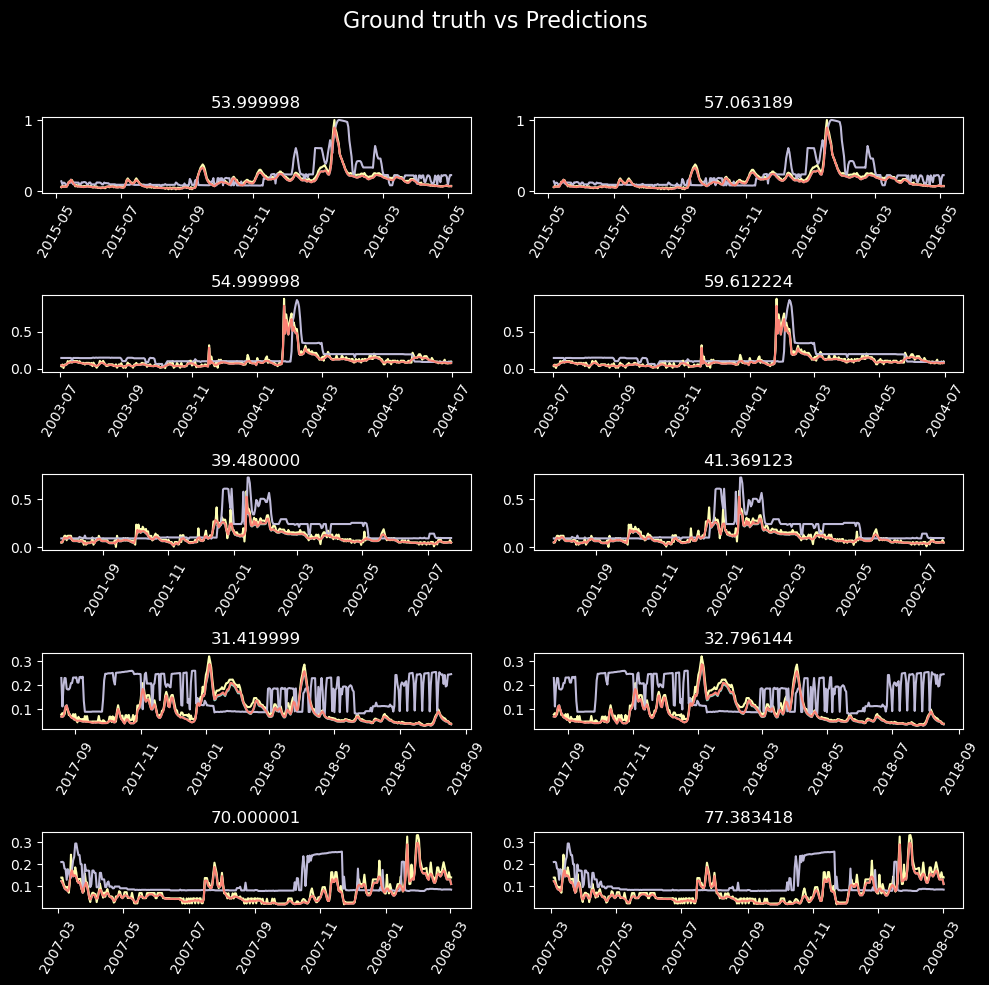

In [39]:
tsmodel_jurumirim.show_results(rows=5)

## Energy Generation forecast & validation  

### Forecasting using the trained TimeSeriesModel 

In [40]:
#Capivara
df_forecasted_capivara = tsmodel_capivara.predict(CapivaraPredict_df, prediction_type="dataframe")
#Chavantes
df_forecasted_chavantes = tsmodel_chavantes.predict(ChavantesPredict_df, prediction_type="dataframe")
#Jurumirim
df_forecasted_jurumirim = tsmodel_capivara.predict(JurumirimPredict_df, prediction_type="dataframe")

In [41]:
print(df_forecasted_capivara)
print(df_forecasted_chavantes)
print(df_forecasted_jurumirim)

      AffluentFlow  DefluentFlow  ...       Date  AffluentNaturalEnergy_results
0          1115.00         541.0  ... 2001-01-01                     591.400000
1          1046.86         759.0  ... 2001-01-02                     581.630000
2          1099.64        1042.0  ... 2001-01-03                     521.180000
3           787.02        1075.0  ... 2001-01-04                     466.780000
4           952.49        1125.0  ... 2001-01-05                     426.140000
...            ...           ...  ...        ...                            ...
8516        411.96         305.0  ... 2024-04-26                    -120.224403
8517        447.05         340.0  ... 2024-04-27                    -119.975677
8518        464.75         304.0  ... 2024-04-28                    -121.187455
8519        457.39         511.0  ... 2024-04-29                    -119.771817
8520        439.61         386.0  ... 2024-04-30                    -118.318782

[8521 rows x 6 columns]
      AffluentF

## Compare actual vs predicted results.

In [42]:
result_capivara_df = pd.DataFrame()
result_capivara_df["Date"] = Series_Chavantes_df["Date"]
result_capivara_df["AffluentNaturalEnergy_actual"] = Series_Capivara_df["AffluentNaturalEnergy"]
result_capivara_df["AffluentNaturalEnergy_predicted"] = df_forecasted_capivara["AffluentNaturalEnergy_results"]

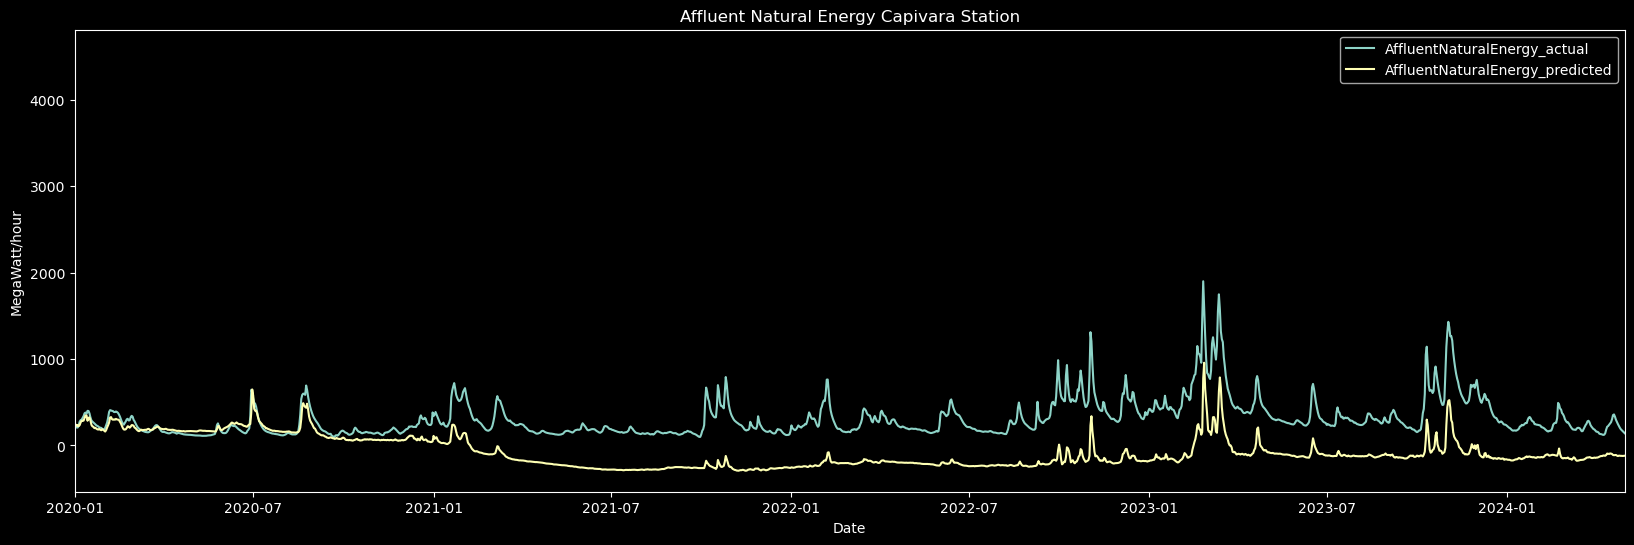

In [51]:
plt.figure(figsize=(20, 6))
plt.plot(result_capivara_df["Date"], 
         result_capivara_df[["AffluentNaturalEnergy_actual", "AffluentNaturalEnergy_predicted"]]
        )
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-04-30'))
plt.xlabel('Date')
plt.ylabel('MegaWatt/hour')
plt.title('Affluent Natural Energy Capivara Station')
plt.legend(["AffluentNaturalEnergy_actual","AffluentNaturalEnergy_predicted" ], loc="upper right")
plt.show()

In [44]:
result_chavantes_df = pd.DataFrame()
result_chavantes_df["Date"] = Series_Chavantes_df["Date"]
result_chavantes_df["AffluentNaturalEnergy_actual"] = Series_Chavantes_df["AffluentNaturalEnergy"]
result_chavantes_df["AffluentNaturalEnergy_predicted"] = df_forecasted_chavantes["AffluentNaturalEnergy_results"]

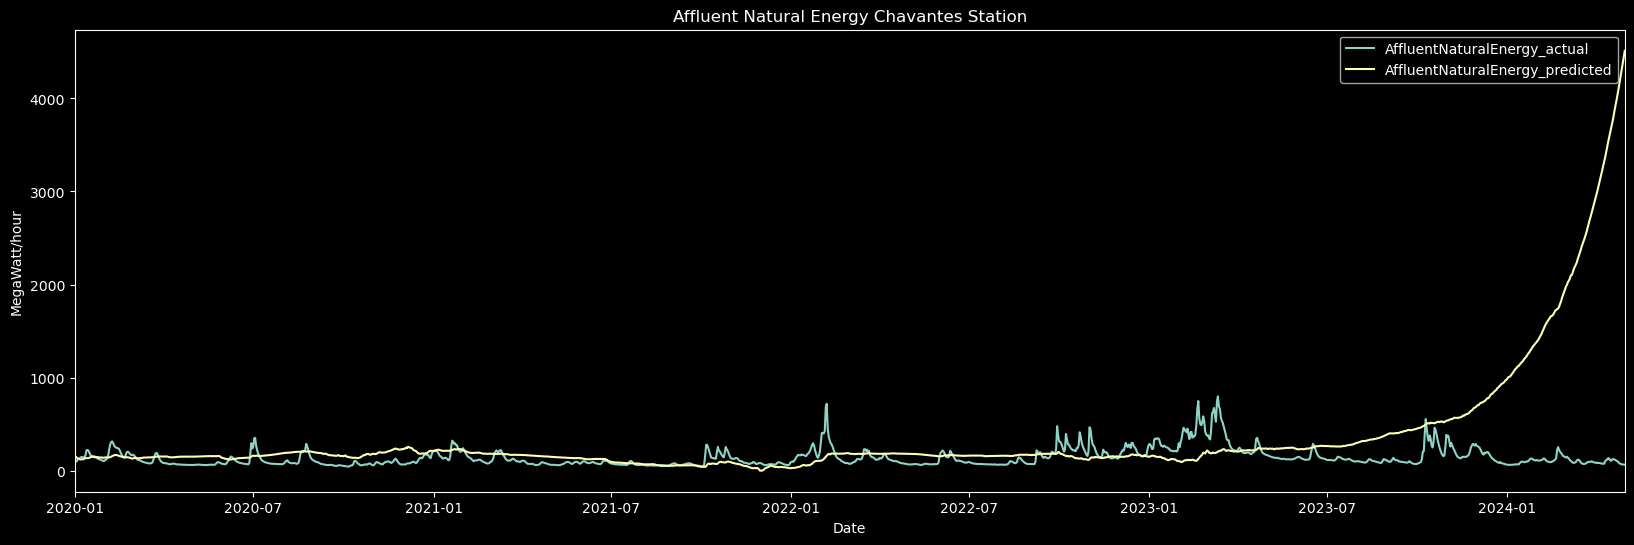

In [52]:
plt.figure(figsize=(20, 6))
plt.plot(result_chavantes_df["Date"], 
         result_chavantes_df[["AffluentNaturalEnergy_actual", "AffluentNaturalEnergy_predicted"]]
        )
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-04-30'))
plt.xlabel('Date')
plt.ylabel('MegaWatt/hour')
plt.title('Affluent Natural Energy Chavantes Station')
plt.legend(["AffluentNaturalEnergy_actual","AffluentNaturalEnergy_predicted" ], loc="upper right")
plt.show()

In [45]:
result_jurumirim_df = pd.DataFrame()
result_jurumirim_df["Date"] = Series_Jurumirim_df["Date"]
result_jurumirim_df["AffluentNaturalEnergy_actual"] = Series_Jurumirim_df["AffluentNaturalEnergy"]
result_jurumirim_df["AffluentNaturalEnergy_predicted"] = df_forecasted_jurumirim["AffluentNaturalEnergy_results"]

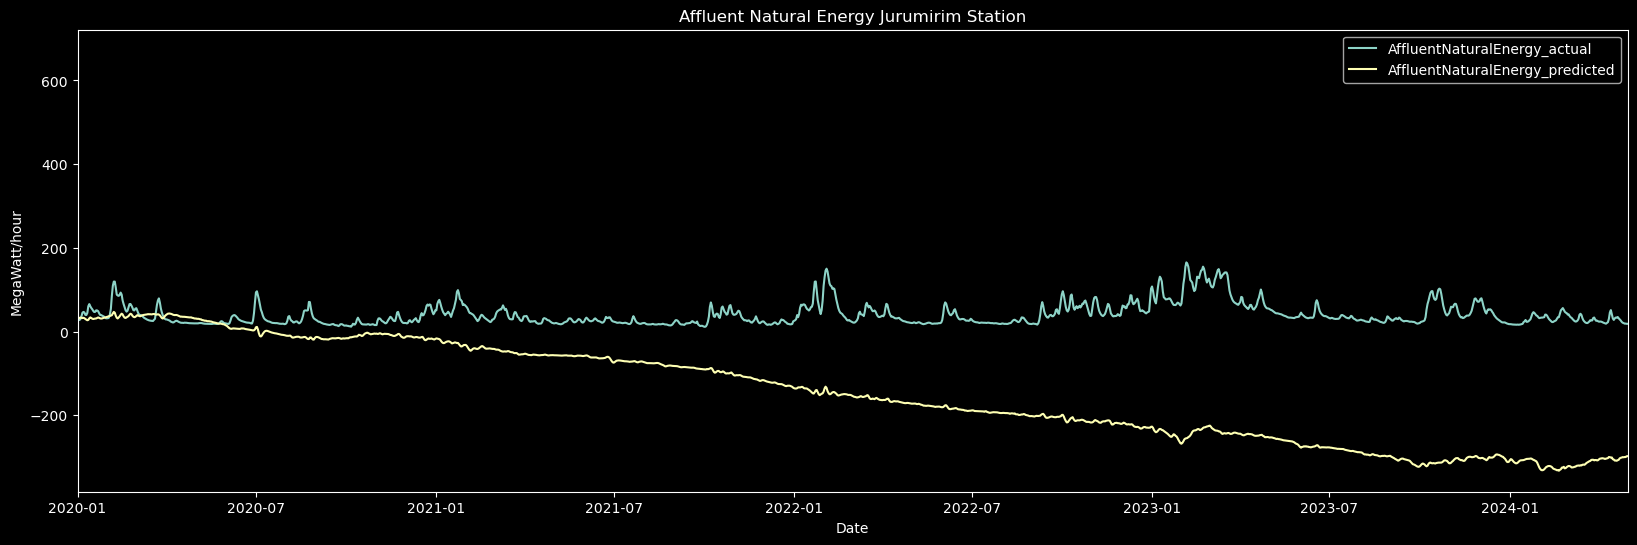

In [53]:
plt.figure(figsize=(20, 6))
plt.plot(result_jurumirim_df["Date"], 
         result_jurumirim_df[["AffluentNaturalEnergy_actual", "AffluentNaturalEnergy_predicted"]]
        )
plt.xlim(pd.Timestamp('2020-01-01'), pd.Timestamp('2024-04-30'))
plt.xlabel('Date')
plt.ylabel('MegaWatt/hour')
plt.title('Affluent Natural Energy Jurumirim Station')
plt.legend(["AffluentNaturalEnergy_actual","AffluentNaturalEnergy_predicted" ], loc="upper right")
plt.show()